# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored in 2016 and has seen impressive results in generating new images; you can read the [original paper, here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the stock price dataset.



So, our goal is to create a DCGAN that can generate new, realistic-looking series. We'll go through the following steps to do this:
* Load in and pre-process the dataset
* Define discriminator and generator networks
* Train these adversarial networks
* Visualize the loss over time and some sample, generated images

#### Deeper Convolutional Networks

We'll need a deeper network to accurately identify patterns in these images and be able to generate new ones. Specifically, we'll use a series of convolutional or transpose convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get these convolutional networks to train. 

Besides these changes in network structure, training the discriminator and generator networks should be the same as before. That is, the discriminator will alternate training on real and fake (generated) series, and the generator will aim to trick the discriminator into thinking that its generated series are real!

In [1]:
# import libraries
import matplotlib.pyplot as plt
import tushare as ts
import numpy as np
import pickle as pkl
import torch
from sklearn import preprocessing
from torch.autograd import Variable
import pandas as pd
%matplotlib inline

## Getting the data

Here you can download the stock dataset. We can load in training data, transform it into Tensor datatypes, then create dataloaders to batch our data into a desired size.

In [2]:

from torchvision import datasets
from torchvision import transforms


#batch_size = 128
batch_size = 1
num_workers = 0

# build DataLoaders for SVHN dataset

data = pd.read_csv('DJIA.csv',header = 0)
data = data.drop(columns = ['Date'])
data = pd.DataFrame(data.values.T, index=data.columns, columns=data.index)
data = np.array(data)
test = np.diff(data)
test = pd.DataFrame(test)
data = pd.DataFrame(data)

In [3]:
test.loc[:,502]=1
data = data.loc[:, (test != 0).any(axis=0)]
test = test.loc[:, (test != 0).any(axis=0)&(test != 1).any(axis=0)]
  # axis=1行，axis=0列

### Visualize the Data



### Pre-processing: scaling from -1 to 1

We need to do a bit of pre-processing; we know that the output of our `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [4]:
'''
sc = preprocessing.MaxAbsScaler()
df['change'] = sc.fit_transform(df['change'].values.reshape(-1,1))
df['close'] = sc.fit_transform(df['close'].values.reshape(-1,1))
'''

print("data after diff",test.shape[1])
result = []
time_steps = 60
print(test.info())
test = test.as_matrix()
for i in range(test.shape[1]-time_steps):
    result.append(test[:,i:i+time_steps])

result = np.array(result)
print("original data after window",result.shape)
print("original data after window",result)
# 训练集和测试集的数据量划分
train_size = int(0.8*result.shape[0])

# 训练集切分
'''
train = result[:train_size,:]
x_train = train[:,:-20]
y_train = train[:, -17:,-1]
x_test = result[train_size:,:-20]
y_test = result[train_size:,-20:,-1]
'''
train = result[:train_size,:,:]
x_train = train[:,:,:-20]
#y_train = train[:, -20:,-1]
y_train = train[:,:,-20:-1]
train_Matrix = train[:,:,:-1]
x_test = result[train_size:,:,:-20]
y_test = result[train_size:,:,-21:-4]
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2])
print("X_train", x_train.shape)
print("y_train", y_train.shape)
print("X_test", x_test.shape)
print("y_test", y_test.shape)
print("x_train one sample",x_train[1,:,:].shape)
print("y_train one sample",y_train[1,:,:].shape)
#print(np.array([np.array([y_train[1,:]])])[0])

#X_train = train_change[:-1]
#y_train = train_change[1:]
#X_test = test_change[:-1]
#y_test = test_change[1:]
'''
name = ['X_train']
stockdata = pd.DataFrame(columns=name,data = X_train)
stockdata['y_train']=y_train
stockdata.to_csv('./data/day_series_000001.csv')

# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())
'''

data after diff 485
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Columns: 485 entries, 0 to 501
dtypes: float64(485)
memory usage: 110.0 KB
None


C:\Users\yangxueying\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


original data after window (425, 29, 60)
original data after window [[[-2.90000e-02  7.74600e-01  1.90760e+00 ...  1.66260e+00  3.13070e+00
   -1.51670e+00]
  [ 5.90500e-01  1.60290e+00  2.23500e-01 ...  1.69040e+00  8.16000e-01
   -1.06290e+00]
  [ 9.14900e-01 -1.07690e+00  1.15979e+01 ...  8.02550e+00 -3.23700e+00
   -4.75020e+00]
  ...
  [ 5.25600e-01 -3.66960e+00  1.23880e+00 ...  6.61000e-02  2.20900e+00
   -2.51110e+00]
  [ 8.23400e-01  8.62000e-02  5.64800e-01 ...  1.20390e+00  4.04500e-01
   -9.05300e-01]
  [ 1.50860e+00  1.08400e-01 -6.32000e-02 ...  1.64270e+00 -1.36900e-01
    0.00000e+00]]

 [[ 7.74600e-01  1.90760e+00 -6.29400e-01 ...  3.13070e+00 -1.51670e+00
    3.11130e+00]
  [ 1.60290e+00  2.23500e-01 -9.03500e-01 ...  8.16000e-01 -1.06290e+00
    8.38600e-01]
  [-1.07690e+00  1.15979e+01  1.24840e+00 ... -3.23700e+00 -4.75020e+00
    1.18275e+01]
  ...
  [-3.66960e+00  1.23880e+00  8.72800e-01 ...  2.20900e+00 -2.51110e+00
    8.59100e-01]
  [ 8.62000e-02  5.64800e-01

"\nname = ['X_train']\nstockdata = pd.DataFrame(columns=name,data = X_train)\nstockdata['y_train']=y_train\nstockdata.to_csv('./data/day_series_000001.csv')\n\n# current range\nimg = images[0]\n\nprint('Min: ', img.min())\nprint('Max: ', img.max())\n"

In [5]:
'''
import data_loader
transformer = transforms.Compose([data_loader.ToTensor()])
stock_train = data_loader.ModelRadarDataset(transform=transformer, mode='train')
train_loader = torch.utils.data.DataLoader(dataset=stock_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
'''

"\nimport data_loader\ntransformer = transforms.Compose([data_loader.ToTensor()])\nstock_train = data_loader.ModelRadarDataset(transform=transformer, mode='train')\ntrain_loader = torch.utils.data.DataLoader(dataset=stock_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)\n"

In [6]:
#compute an analysis value a for each asset:
def normalization(s):
    a = np.array(s)
    b = (np.max(a)-np.min(a))/np.mean(a)
    return b
#define the analysis vector A as the vector representation of a to consider multiple assets.
#A = [normalization(test)]

'''
# helper scale function
def scale(x, feature_range=(-1, 1)):
#Scale takes in an image x and returns that image, scaled
#       with a feature_range of pixel values from -1 to 1. 
#       This function assumes that the input x is already scaled from 0-1.
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x
'''
def scale(x):
    sc = preprocessing.MaxAbsScaler()
    b = sc.fit_transform(x.reshape(-1,1))
    return b

def denormalization(x,s):
    a = np.array(s)
    x=x*(np.max(a)-np.min(a))+np.min(a);
    return x

---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Here you'll build the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. 
* The inputs to the discriminator are tensor series
* You'll want a few convolutional, hidden layers
* Then a fully connected layer for the output; as before, we want a sigmoid output, but we'll add that in the loss function, [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss), later


For the depths of the convolutional layers I suggest starting with 32 filters in the first layer, then double that depth as you add layers (to 64, 128, etc.). Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpooling layers.

You'll also want to use batch normalization with [nn.BatchNorm1d](https://pytorch.org/docs/stable/nn.html#batchnorm2d) on each layer **except** the first convolutional layer and final, linear output layer. 

#### Helper `conv` function 

In general, each layer should look something like convolution > batch norm > leaky ReLU, and so we'll define a function to put these layers together. This function will create a sequential series of a convolutional + an optional batch norm layer. We'll create these using PyTorch's [Sequential container](https://pytorch.org/docs/stable/nn.html#sequential), which takes in a list of layers and creates layers according to the order that they are passed in to the Sequential constructor.

Note: It is also suggested that you use a **kernel_size of 5** and a **stride of 2** for strided convolutions.

In [7]:
import torch.nn as nn
import torch.nn.functional as F


# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=(1,2), padding=(0,2), batch_norm=False):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm1d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)


In [8]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=29):
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim

        # 32x32 input
        self.conv1 = conv(1, conv_dim*2, (1,5), batch_norm=False) # first layer, no batch_norm
        # 16x16 out
        self.conv2 = conv(conv_dim*2, conv_dim*4, (1,5))
        # 8x8 out
        self.conv3 = conv(conv_dim*4, conv_dim*8, (1,5))
        # 4x4 out
        self.conv4 = conv(conv_dim*8, conv_dim*16, (1,5))
        #
        self.conv5 = conv(conv_dim*16, conv_dim*32, (1,5))
        
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*2*conv_dim*32, 1)
#        self.fc = nn.Linear(conv_dim*16, 1)

    def forward(self, x, a):
        
        # all hidden layers + leaky relu activation
        out = F.leaky_relu(self.conv1(x), 0.2)
        print("discriminator conv1",out.size())
        out = F.leaky_relu(self.conv2(out), 0.2)
        print("discriminator conv2",out.size())
        out = F.leaky_relu(self.conv3(out), 0.2)
        print("discriminator conv3",out.size())
        out = F.leaky_relu(self.conv4(out), 0.2)
        print("discriminator conv4",out.size())
        out = F.leaky_relu(self.conv5(out), 0.2)
        print("discriminator conv5",out.size())
#leaky_relu(0.2) 参考Takahashi, S. & Chen, Y. & Tanaka-Ishii, K. (2019). Modeling financial time-series with generative adversarial networks. Physica A: Statistical Mechanics and its Applications. 527. 121261. 10.1016/j.physa.2019.121261.
        #concat with A
#        out = torch.cat((a, out),axis=0)
        # flatten
        out = out.view(-1, self.conv_dim*self.conv_dim*2*32)
#        out = out.view(-1, self.conv_dim*16)
        print("discriminator fc input",out.size())
        # final output layer
        out = self.fc(out)
        print("discriminator output",out.size())
        print("discriminator output",out)
        return out
    

## Generator

Next, you'll build the generator network. The input will be our noise vector `z`, as before. And, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use transpose convolutional layers to create our new series. 
* The first layer is a fully connected layer which is reshaped into a deep and narrow layer. 
* Then, we use batch normalization and a leaky ReLU activation. 
* Next is a series of [transpose convolutional layers](https://pytorch.org/docs/stable/nn.html#convtranspose2d), where you typically halve the depth and double the width and height of the previous layer. 
* And, we'll apply batch normalization and ReLU to all but the last of these hidden layers. Where we will just apply a `tanh` activation.

#### Helper `deconv` function

For each of these layers, the general scheme is transpose convolution > batch norm > ReLU, and so we'll define a function to put these layers together. This function will create a sequential series of a transpose convolutional + an optional batch norm layer. We'll create these using PyTorch's Sequential container, which takes in a list of layers and creates layers according to the order that they are passed in to the Sequential constructor.

Note: It is also suggested that you use a **kernel_size of 5** and a **stride of 2** for transpose convolutions.

In [9]:
## Size of latent vector to genorator
f_size = 29

# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=(1,2), padding=(0,2), batch_norm=False):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm1d(out_channels))
        
    return nn.Sequential(*layers)


In [10]:
class Generator(nn.Module):
    
    def __init__(self, f_size, conv_dim=29):
        super(Generator, self).__init__()

        # complete init function
        
        self.conv_dim = conv_dim
        
        #conditioning
        self.t_cconv1 = conv(1, conv_dim*2, (1,5))
        self.t_cconv2 = conv(conv_dim*2, conv_dim*2, (1,5))
        self.t_cconv3 = conv(conv_dim*2, conv_dim*2, (1,5))
        self.t_cconv4 = conv(conv_dim*2, conv_dim*2, (1,5))
        
        # conditioning fully-connected layer
        self.fc1 = nn.Linear(conv_dim*2*conv_dim*3, conv_dim)
        
        # simulator fully-connected layer
        self.fc2 = nn.Linear(f_size+conv_dim, 20*conv_dim)
        
        # transpose conv layers
        self.t_sconv1 = deconv(4, 2, (1,5))
        self.t_sconv2 = deconv(2, 1, (1,5))
#        self.t_sconv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        

    def forward(self, x,y):
        
        # hidden transpose conv layers + relu
#        print(x.size())
        out = F.relu(self.t_cconv1(x))
        print("generator cconv1",out.size())
        out = F.relu(self.t_cconv2(out))
        print("generator cconv2",out.size())
        out = F.relu(self.t_cconv3(out))
        print("generator cconv3",out.size())
        out = F.relu(self.t_cconv4(out))#(1,2,3)
        print("generator cconv4",out.size())
        
        # fully-connected + reshape 
        out = out.view(-1, self.conv_dim*self.conv_dim*2*3)
        print("generator fc1 input",out.size())
        out = self.fc1(out)
        print("generator fc2 output, to be concated",out.size())
#        out = out.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
        
        #concat with A
#        out = torch.cat((A, out),axis=0)

        #concat with latent vector
        out = torch.Tensor(np.concatenate((out.detach().numpy(), y.detach().numpy()), axis=1))
        print("generator after concat",out.size())#（1，5）
        
        # fully-connected + reshape 
        out = self.fc2(out)
        print("generator fc2",out.size())
#        out=torch.unsqueeze(out,0)
        
        out = out.view(1, 4, self.conv_dim, 5) # (batch_size, depth, 4, 4)
        
        out = F.relu(self.t_sconv1(out))
#       print(out.size())
        out = F.relu(self.t_sconv2(out))
        print("generator_out size",out.size())
        print("generator_out",out)
        
        # last layer + tanh activation
#        out = self.t_conv3(out)
#        out = F.tanh(out)
        
        return out
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [11]:
# define hyperparams
#number of assets k
#conv_dim = 2
## Size of latent vector to genorator
f_size = 29

# define discriminator and generator
#D = Discriminator(conv_dim)
#G = Generator(f_size=f_size, conv_dim=conv_dim)
D = Discriminator()
G = Generator(f_size=f_size)

print(D)
print()
print(G)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(1, 58, kernel_size=(1, 5), stride=(1, 2), padding=(0, 2), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(58, 116, kernel_size=(1, 5), stride=(1, 2), padding=(0, 2), bias=False)
  )
  (conv3): Sequential(
    (0): Conv2d(116, 232, kernel_size=(1, 5), stride=(1, 2), padding=(0, 2), bias=False)
  )
  (conv4): Sequential(
    (0): Conv2d(232, 464, kernel_size=(1, 5), stride=(1, 2), padding=(0, 2), bias=False)
  )
  (conv5): Sequential(
    (0): Conv2d(464, 928, kernel_size=(1, 5), stride=(1, 2), padding=(0, 2), bias=False)
  )
  (fc): Linear(in_features=53824, out_features=1, bias=True)
)

Generator(
  (t_cconv1): Sequential(
    (0): Conv2d(1, 58, kernel_size=(1, 5), stride=(1, 2), padding=(0, 2), bias=False)
  )
  (t_cconv2): Sequential(
    (0): Conv2d(58, 58, kernel_size=(1, 5), stride=(1, 2), padding=(0, 2), bias=False)
  )
  (t_cconv3): Sequential(
    (0): Conv2d(58, 58, kernel_size=(1, 5), stride=(1, 2), padding=(0, 2), 

### Training on GPU

Check if you can train on GPU. If you can, set this as a variable and move your models to GPU. 
> Later, we'll also move any inputs our models and loss functions see (real_images, z, and ground truth labels) to GPU as well.

In [12]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    # move models to GPU
    G.cuda()
    D.cuda()
    print('GPU available for training. Models moved to GPU')
else:
    print('Training on CPU.')
    

Training on CPU.


---
## Discriminator and Generator Losses

Now we need to calculate the losses. And this will be exactly the same as before.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.

The losses will by binary cross entropy loss with logits, which we can get with [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss). This combines a `sigmoid` activation function **and** and binary cross entropy loss in one function.

For the real images, we want `D(real_images) = 1`. That is, we want the discriminator to classify the the real images with a label = 1, indicating that these are real. The discriminator loss for the fake data is similar. We want `D(fake_images) = 0`, where the fake images are the _generator output_, `fake_images = G(z)`. 

### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get `D(fake_images) = 1`. In this case, the labels are **flipped** to represent that the generator is trying to fool the discriminator into thinking that the images it generates (fakes) are real!

In [13]:
def real_loss(D_out, smooth=False):
    batch_size = 1
#    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
#    criterion = nn.BCEWithLogitsLoss()
#    criterion = nn.CrossEntropyLoss()
    # calculate loss
#    print("labels",labels)
#    print("labels_shape",labels.size())
#    labels= torch.LongTensor(labels)
#    print('D_out',D_real)
#    print('D_shape',D_real.shape)
    labels = labels.to(dtype=torch.int64)
#    loss = criterion(D_out.squeeze(), labels)
#    loss = criterion(D_out.view(-1,0), labels)
#    loss = criterion(D_out,labels)
    loss = -torch.mean(D_out)
    return loss

def fake_loss(D_out):
#    batch_size = D_out.size(0)
    batch_size = 1
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
#    criterion = nn.BCEWithLogitsLoss()
#    criterion = nn.CrossEntropyLoss()
    # calculate loss
#    loss = criterion(D_out.squeeze(), labels)
#    loss = criterion(D_out, labels)
    loss = -torch.mean(D_out)
    return loss

## Optimizers

Not much new here, but notice how I am using a small learning rate and custom parameters for the Adam optimizers, This is based on some research into DCGAN model convergence.

### Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

In [14]:
import torch.optim as optim

# params
lr = 0.00002
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. We'll use our functions `real_loss` and `fake_loss` to help us calculate the discriminator losses in all of the following cases.

### Discriminator training
1. Compute the discriminator loss on real, training images        
2. Generate fake images
3. Compute the discriminator loss on fake, generated images     
4. Add up real and fake loss
5. Perform backpropagation + an optimization step to update the discriminator's weights

### Generator training
1. Generate fake images
2. Compute the discriminator loss on fake images, using **flipped** labels!
3. Perform backpropagation + an optimization step to update the generator's weights

#### Saving Samples

As we train, we'll also print out some loss statistics and save some generated "fake" samples.

**Evaluation mode**

Notice that, when we call our generator to create the samples to display, we set our model to evaluation mode: `G.eval()`. That's so the batch normalization layers will use the population statistics rather than the batch statistics (as they do during training), *and* so dropout layers will operate in eval() mode; not turning off any nodes for generating samples.

In [15]:
import pickle as pkl

# training hyperparams
num_epochs = 50

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 300

# Get some fixed data for sampling. These are series that are held
# constant throughout training, and allow us to inspect the model's performance

#five representative simulations
sample_size=5
#fixed_z = np.random.uniform(-1, 1, size=(sample_size, f_size))
#fixed_z = torch.from_numpy(fixed_z).float()
fixed_z1 = Variable(torch.Tensor(np.random.normal(0, 1, (batch_size, f_size))))
#fixed_z = torch.cat((fixed_z1,fixed_z2),1)
        
        

# train the network
#for epoch in range(num_epochs):
for epoch in range(1):    
#    for batch_i, (real_series, _) in enumerate(train_loader):
#    for batch_i, sample in enumerate(train_loader):
    for idx in range(1):

#        print(real_series)
#        real_series=real_series.permute(0,2,1)
#        print(real_series)
#        observation = torch.Tensor(np.array([np.array([y_train[idx,:,:]])]))
#        print(y_train[idx,::])
#        observation=observation.permute(0,2,1)
#        print("observation",observation.size())
        
#        print("batch_size",real_series.size(0))
        # important rescaling step
    #        real_series = scale(real_series)
        
        real_series = train_Matrix[idx,:,:]
        print("real_series",real_series.shape)
        print("real_series",real_series)
        A = torch.Tensor(np.apply_along_axis(normalization, 1, real_series))
        print("A",A)
        print("A",A.size())
        real_series = np.apply_along_axis(scale, 1, real_series)
        real_series=torch.squeeze(torch.Tensor(real_series),2)

        real_series = torch.Tensor([[np.array(real_series)]])
        print("real_series after scale",real_series.size())
        batch_size = real_series.size(0)
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================

        d_optimizer.zero_grad()

        # 1. Train with real images

        # Compute the discriminator losses on real images 
    #        if train_on_gpu:
    #            real_series = real_series.cuda()

        D_real = D(real_series,A)

        d_real_loss = real_loss(D_real)

        # 2. Train with fake series

        # Generate fake series
    #       z = np.random.uniform(-1, 1, size=(batch_size, z_size))
    #        z = torch.from_numpy(z).float()
    #normal distribution
        part_realseries = torch.Tensor([[np.array(x_train[idx,:,:])]])
        z1 = Variable(torch.Tensor(np.random.normal(0, 1, (batch_size, f_size))))
#        z2 = Variable(torch.Tensor(np.random.normal(0, 1, (batch_size, f_size))))
#        z = torch.cat((fixed_z1,fixed_z2),1)
        print("z",z1)
        print("z_shape",z1.size())
        # move x to GPU, if available
#        if train_on_gpu:
#            z = z.cuda()
        part_fakeseries = G(x=part_realseries,y=z1)
#        fake_series2 = G(x=part_realseries,y=z2)
        fake_series = torch.cat((part_realseries,part_fakeseries),3)
#        print("fake_series1",fake_series1.size())
        
        # Compute the discriminator losses on fake series            
        D_fake = D(fake_series,A)
        d_fake_loss = fake_loss(D_fake)

        # add up loss and perform backprop
        d_loss = d_real_loss - d_fake_loss
        '''
        alpha = Variable(torch.Tensor(np.random.uniform(0, 1, size=(17, 1))))
        print("alpha",alpha.size())
        differences = (fake_series1 - observation)[0]
        print(differences.size())
        print((alpha*differences).size())
        interpolates = observation[0] + (alpha*differences)
        print(interpolates.size())
        interpolates = torch.Tensor(np.array([interpolates])).permute(0,2,1)
        interpolates = torch.cat((interpolates,interpolates),1)
        gradients = torch.autograd.grad(D(interpolates), [interpolates])[0]
        slopes = torch.sqrt(torch.mean(torch.square(gradients), reduction_indices=[1]))
        gradient_penalty = torch.mean((slopes-1.)**2)
        d_loss += 10*gradient_penalty
        '''
        d_loss.backward()
        d_optimizer.step()


        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()

        # 1. Train with fake images and flipped labels

        # Generate fake series
    #        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
    #        z = torch.from_numpy(z).float()
    #normal distribution
        z1 = Variable(torch.Tensor(np.random.normal(0, 1, (batch_size, f_size))))
#        z2 = Variable(torch.Tensor(np.random.normal(0, 1, (batch_size, f_size))))
#        if train_on_gpu:
#            z = z.cuda()
        part_fakeseries = G(x=part_realseries,y=z1)
#        fake_series2 = G(x=real_series,y=z2)
        fake_series = torch.cat((part_realseries,part_fakeseries),3)

        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_series,A)
        g_loss = real_loss(D_fake) # use real loss to flip labels

        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if idx % print_every == 0:
            # append discriminator loss and generator loss
            losses.append((d_loss.item(), g_loss.item()))
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##    
    # generate and save sample, fake images
    G.eval() # for generating samples
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
#    for idx in range(551):
    samples_z = G(x=torch.Tensor([[np.array(x_test[0,:,:])]]),y=fixed_z1)
#    samples.append(samples_z)
#    samples = sc.inverse_transform(samples)
    print("samples",samples)
#    samples.append(samples_z)
    
    G.train() # back to training mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples_z, f)

real_series (29, 59)
real_series [[-0.029   0.7746  1.9076 ... -1.0695  1.6626  3.1307]
 [ 0.5905  1.6029  0.2235 ... -2.2149  1.6904  0.816 ]
 [ 0.9149 -1.0769 11.5979 ... -5.2098  8.0255 -3.237 ]
 ...
 [ 0.5256 -3.6696  1.2388 ... -2.2374  0.0661  2.209 ]
 [ 0.8234  0.0862  0.5648 ... -3.2939  1.2039  0.4045]
 [ 1.5086  0.1084 -0.0632 ... -1.2685  1.6427 -0.1369]]
A tensor([17984.9414,  -101.8235,    67.1928,   -75.4020,    75.5720,   -56.9757,
          -40.7834,  -550.3893,  -115.7437,   491.1803,   135.0129,   -82.0486,
          144.0835,  -175.6429,   -61.2629,   -73.3833,  -273.1716,    97.2493,
           71.6703,  8913.6582,   -24.8668,   112.3597,   135.5108,  -523.0107,
          101.6431,   -47.5814,   -42.3153,   -59.9371,   -41.6297])
A torch.Size([29])
real_series after scale torch.Size([1, 1, 29, 59])
discriminator conv1 torch.Size([1, 58, 29, 30])
discriminator conv2 torch.Size([1, 116, 29, 15])
discriminator conv3 torch.Size([1, 232, 29, 8])
discriminator conv4 torch

           0.0000e+00, 0.0000e+00]]]], grad_fn=<ReluBackward0>)
discriminator conv1 torch.Size([1, 58, 29, 29])
discriminator conv2 torch.Size([1, 116, 29, 15])
discriminator conv3 torch.Size([1, 232, 29, 8])
discriminator conv4 torch.Size([1, 464, 29, 4])
discriminator conv5 torch.Size([1, 928, 29, 2])
discriminator fc input torch.Size([1, 53824])
discriminator output torch.Size([1, 1])
discriminator output tensor([[0.0139]], grad_fn=<AddmmBackward>)
generator cconv1 torch.Size([1, 58, 29, 20])
generator cconv2 torch.Size([1, 58, 29, 10])
generator cconv3 torch.Size([1, 58, 29, 5])
generator cconv4 torch.Size([1, 58, 29, 3])
generator fc1 input torch.Size([1, 5046])
generator fc2 output, to be concated torch.Size([1, 29])
generator after concat torch.Size([1, 58])
generator fc2 torch.Size([1, 580])
generator_out size torch.Size([1, 1, 29, 17])
generator_out tensor([[[[0.1921, 0.1771, 0.2802, 0.1074, 0.0000, 0.0000, 0.0000, 0.1311,
           0.0566, 0.0000, 0.0000, 0.0000, 0.0000, 0.0

           0.0000]]]], grad_fn=<ReluBackward0>)
samples []


## Training loss

Here we'll plot the training losses for the generator and discriminator, recorded after each epoch.

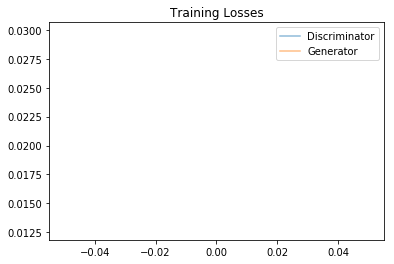

In [16]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [47]:
predict = denormalization(torch.squeeze(torch.Tensor(scale(samples_z[0,0,0,:].detach().numpy())),1),np.array(x_test[0,0,:]))
t = np.concatenate((x_test[0,0,:], np.array(predict)))
t

array([ -0.5747    ,   1.5755    ,  -0.6738    ,  -0.1982    ,
        -2.9825    ,   4.1914    ,  -0.0595    ,  -1.8034    ,
         3.5969    ,   1.1693    ,   1.6646    ,  -0.1783    ,
        -4.1716    ,   1.2089    ,   1.9718    ,  -1.4665    ,
         1.5359    ,   1.8926    ,  -0.7036    ,  -1.1395    ,
         2.2889    ,  -3.042     ,   4.5878    ,   1.6053    ,
        -0.1685    ,  -1.635     ,   0.7135    ,   1.9223    ,
        -0.8918    ,   4.2212    ,  -4.568     ,  -4.3698    ,
       -10.5826    ,   3.6266    ,   2.0214    ,   4.35      ,
        -1.6611    ,  -0.5073    ,   8.4446    ,  -6.1867    ,
       -10.58259964, -10.58259964,   0.16599846,  -6.2233119 ,
        -8.7011795 , -10.58259964, -10.58259964, -10.58259964,
         4.22805405,   1.71152973,   8.44460106, -10.58259964,
        -7.14711189, -10.58259964, -10.58259964, -10.58259964,
        -7.33272743])

In [48]:
p = np.empty((57))
p

array([ 0.5747    ,  1.5755    ,  0.6738    ,  0.1982    ,  2.9825    ,
        4.1914    ,  0.0595    ,  1.8034    ,  3.5969    ,  1.1693    ,
        1.6646    ,  0.1783    ,  4.1716    ,  1.2089    ,  1.9718    ,
        1.4665    ,  1.5359    ,  1.8926    ,  0.7036    ,  1.1395    ,
        2.2889    ,  3.042     ,  4.5878    ,  1.6053    ,  0.1685    ,
        1.635     ,  0.7135    ,  1.9223    ,  0.8918    ,  4.2212    ,
        4.568     ,  4.3698    , 10.5826    ,  3.6266    ,  2.0214    ,
        4.35      ,  1.6611    ,  0.5073    ,  8.4446    ,  6.1867    ,
       10.58259964, 10.58259964,  0.16599846,  6.2233119 ,  8.7011795 ,
       10.58259964, 10.58259964, 10.58259964,  4.22805405,  1.71152973,
        8.44460106, 10.58259964,  7.14711189, 10.58259964, 10.58259964,
       10.58259964,  7.33272743])

In [49]:
sum(t[:9])

3.0716999999999928

In [50]:
for i in range(57):
    p[i] = data.loc[0,340] + sum(t[:i])
    print(p[i])

176.6741
176.0994
177.6749
177.0011
176.80290000000002
173.8204
178.01180000000002
177.9523
176.1489
179.7458
180.91510000000002
182.5797
182.40140000000002
178.2298
179.4387
181.4105
179.94400000000002
181.47990000000001
183.3725
182.6689
181.5294
183.81830000000002
180.77630000000002
185.3641
186.9694
186.8009
185.16590000000002
185.8794
187.8017
186.90990000000002
191.1311
186.56310000000002
182.19330000000002
171.6107
175.2373
177.2587
181.6087
179.94760000000002
179.4403
187.88490000000002
181.6982
171.11560036010744
160.53300072021486
160.69899917907716
154.47568727798463
145.7745077735901
135.19190813369752
124.60930849380495
114.02670885391237
118.25476290054323
119.96629263229372
128.41089369125368
117.8282940513611
110.6811821586609
100.09858251876832
89.51598287887575
78.93338323898317


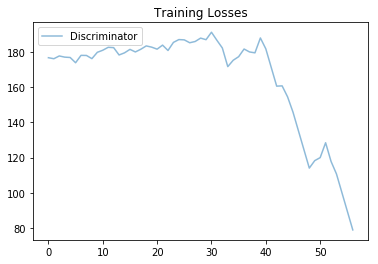

In [51]:
fig, ax = plt.subplots()
plt.plot(p, label='Discriminator', alpha=0.5)
#plt.plot(samples, label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

C:\Users\yangxueying\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Users\yangxueying\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Users\yangxueying\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot int

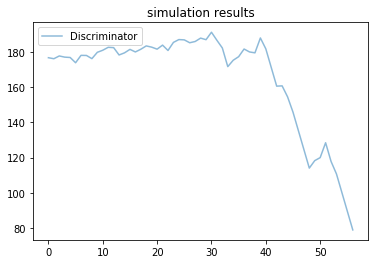

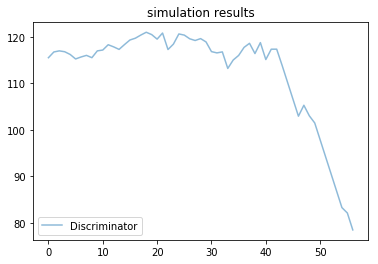

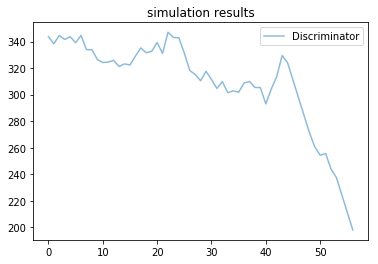

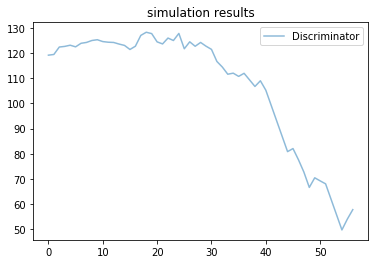

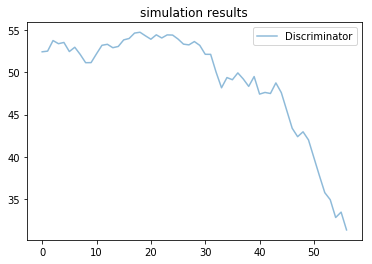

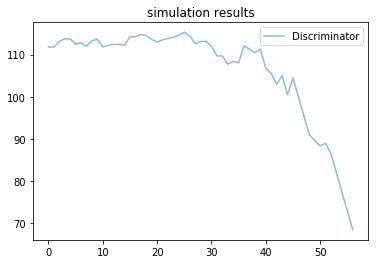

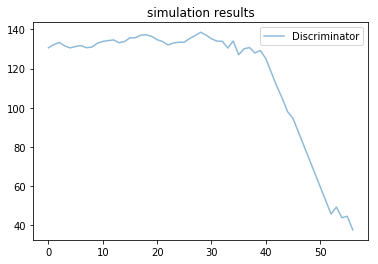

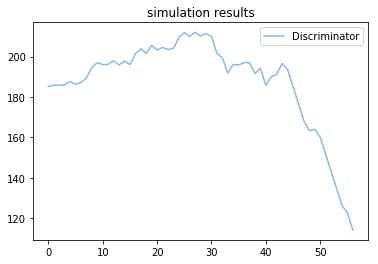

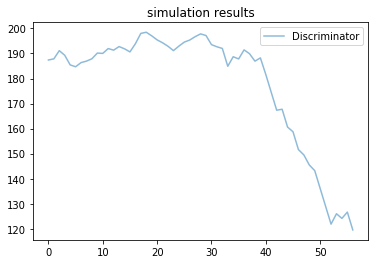

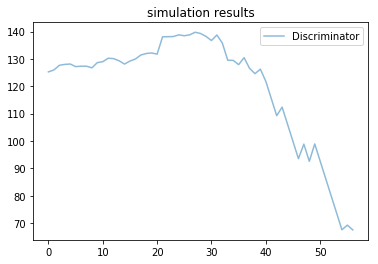

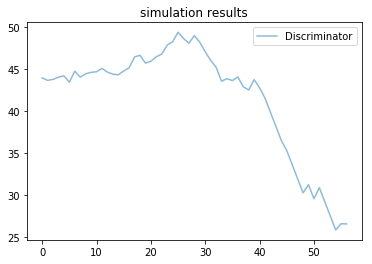

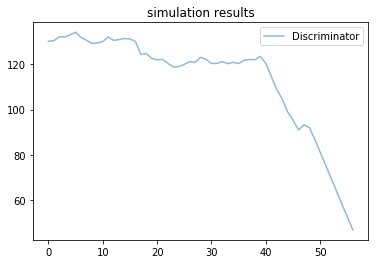

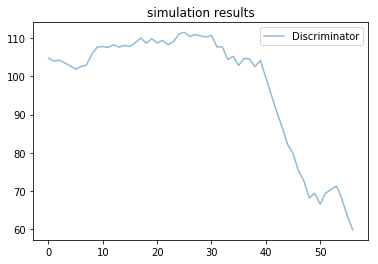

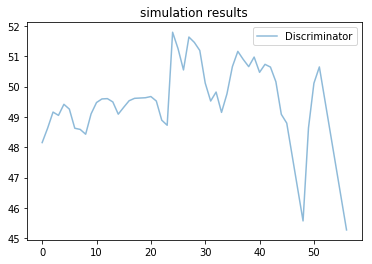

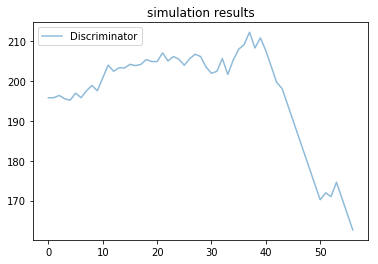

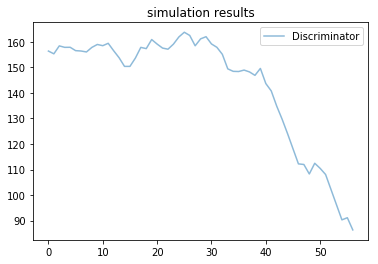

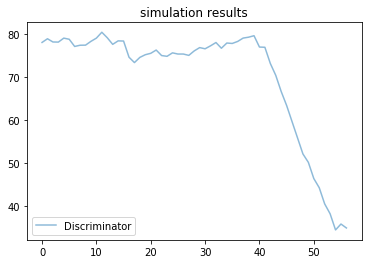

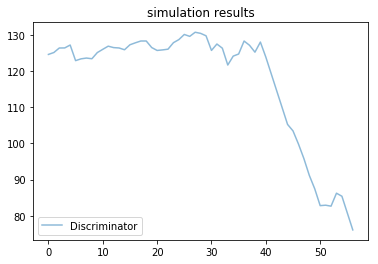

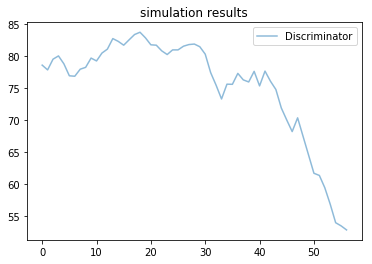

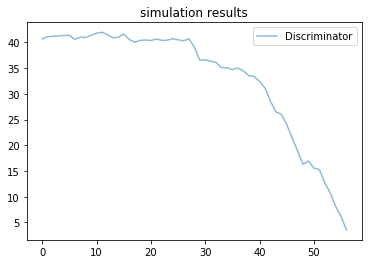

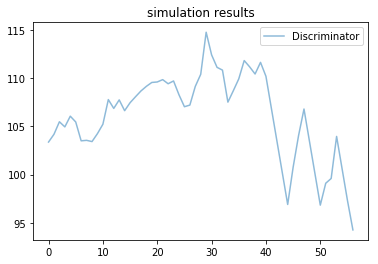

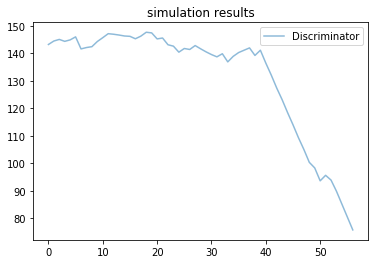

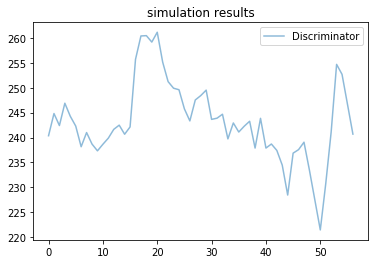

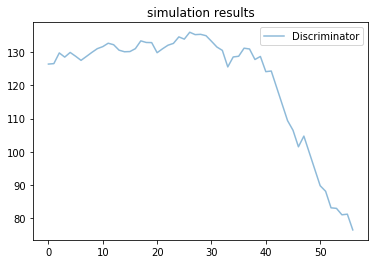

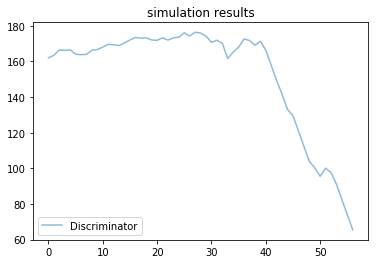

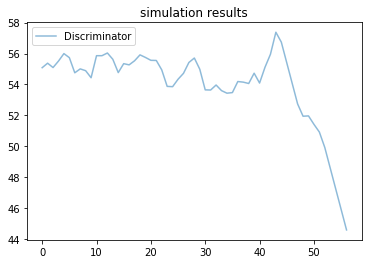

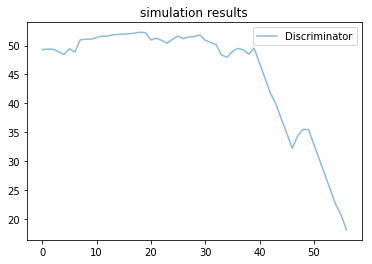

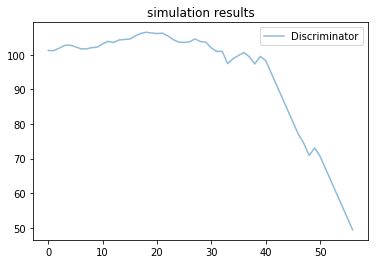

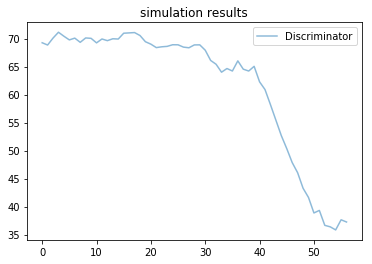

In [53]:
for j in range(29):
    predict = denormalization(torch.squeeze(torch.Tensor(scale(samples_z[0,0,j,:].detach().numpy())),1),np.array(x_test[0,j,:]))
    t = np.concatenate((x_test[0,j,:], np.array(predict)))
    p=np.empty((57))
    for i in range(57):
        p[i] = data.loc[j,340]+sum(t[:i])

    fig, ax = plt.subplots()
    plt.plot(p, label='Discriminator', alpha=0.5)
    #plt.plot(samples, label='Generator', alpha=0.5)
    plt.title("simulation results")
    plt.legend()

## Generator samples from training

Here we can view samples of images from the generator. We'll look at the images we saved during training.

In [ ]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [ ]:
_ = view_samples(-1, samples)

In [ ]:
print(fixed_z1)

In [ ]:
print(G(fixed_z1))